<a href="https://colab.research.google.com/github/Kang-Yoonah/BigAi/blob/gh-pages/3/HandsOn/Chapter6_Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 연습문제

## 7번

In [33]:
import sys
assert sys.version_info >= (3, 5)

import sklearn
assert sklearn.__version__ >= "0.20"

import numpy as np
import os
import warnings
warnings.filterwarnings(action='ignore')

np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [34]:
from sklearn.datasets import make_moons   #  초승달 모양 클러스터 두 개 형상의 데이터를 생성
X, y = make_moons(n_samples=1000, noise=0.4, random_state=53)

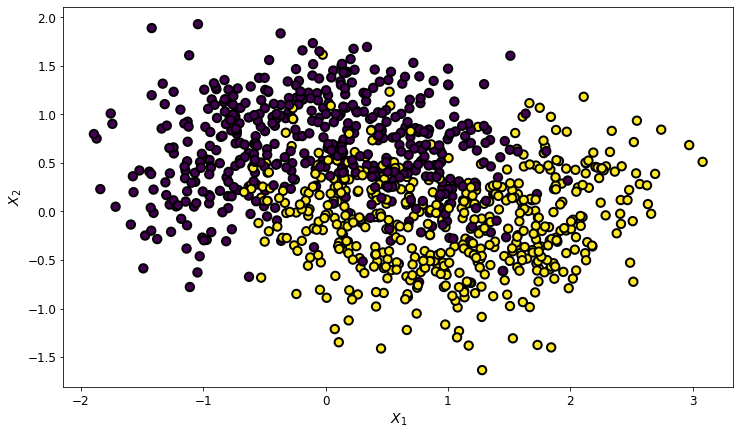

In [35]:
plt.figure(figsize=(12,7))
plt.scatter(X[:, 0], X[:, 1], marker='o', c = y, s=70,
            edgecolor="k", linewidth=2)
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.show()

In [36]:
# 훈련 데이터, 테스트 데이터 나누기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify = y, random_state=42)

In [37]:
# 모델 생성
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score, accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42) # max_depth : 최대 깊이 

In [38]:
kfold = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
cv_accuracy = []

n_iter = 0
for train_idx, test_idx in kfold.split(x_train,y_train):
    X_train, X_test = x_train[train_idx], x_train[test_idx]
    Y_train, Y_test = y_train[train_idx], y_train[test_idx]

    tree_clf.fit(X_train,Y_train)
    fold_pred = tree_clf.predict(X_test)

    #정확도 측정
    n_iter +=1
    accuracy = np.round(roc_auc_score(Y_test,fold_pred), 4)
    cv_accuracy.append(accuracy)
    print(f'{n_iter} 교차검증 정확도: {accuracy}, 학습데이터 크기: {X_train.shape[0]}, 검증데이터 크기: {X_test.shape[0]}')
print('\n 평균 검증 정확도: ',np.mean(cv_accuracy))

1 교차검증 정확도: 0.7308, 학습데이터 크기: 466, 검증데이터 크기: 234
2 교차검증 정확도: 0.7553, 학습데이터 크기: 467, 검증데이터 크기: 233
3 교차검증 정확도: 0.7639, 학습데이터 크기: 467, 검증데이터 크기: 233

 평균 검증 정확도:  0.75


In [39]:
cv_results = cross_val_score(tree_clf, x_train, y_train, cv=kfold,
                             scoring="accuracy", n_jobs=-1)
print(cv_results.mean())
print(cv_results)

0.750027511830087
[0.73076923 0.75536481 0.7639485 ]


In [40]:
from sklearn.model_selection import GridSearchCV

param_grid = {
              "min_samples_leaf":[1, 2, 3, 4, 5, 6, 7, 8, 9],
              "min_samples_split":[2, 3, 4, 5, 6, 7, 8, 9, 10],
              'max_leaf_nodes':[3,4,5,6,7,8,9,10,11,12,13]
}
gs = GridSearchCV(tree_clf, param_grid = param_grid, 
                  scoring = 'accuracy', cv = 3,
                  verbose = 1, n_jobs = -1)
gs.fit(x_train,y_train)

print(gs.best_score_)
print(gs.best_params_)

Fitting 3 folds for each of 891 candidates, totalling 2673 fits
0.8299463213626304
{'max_leaf_nodes': 7, 'min_samples_leaf': 7, 'min_samples_split': 2}


In [41]:
tree_clf2 = DecisionTreeClassifier(max_leaf_nodes = 7,
                                   min_samples_leaf = 7,
                                   min_samples_split = 2,
                                   random_state=42)

param_grid2 = {
              "max_depth":np.arange(3,30),
              "max_leaf_nodes":np.arange(1,20)
              }
gs2 = GridSearchCV(tree_clf2, param_grid = param_grid2,
                  scoring = 'accuracy', cv = 3,
                  verbose = 1, n_jobs = -1)
gs2.fit(x_train, y_train)

print(gs2.best_score_)
print(gs2.best_params_)

Fitting 3 folds for each of 513 candidates, totalling 1539 fits
0.8313463678270545
{'max_depth': 7, 'max_leaf_nodes': 17}


In [42]:
tree_clf0 = DecisionTreeClassifier(max_depth = 7,
                                   max_leaf_nodes = 17,
                                   min_samples_leaf = 1,
                                   min_samples_split = 2,
                                   random_state=42)

cv_results = cross_val_score(tree_clf0, x_train, y_train, cv=kfold,
                             scoring="accuracy", n_jobs=-1)
print(cv_results.mean())
print(cv_results)

0.784307252118411
[0.76923077 0.8111588  0.77253219]


In [43]:
tree_clf0.fit(x_train,y_train)
predict = tree_clf0.predict(x_test)
print(accuracy_score(y_test, predict))

0.88


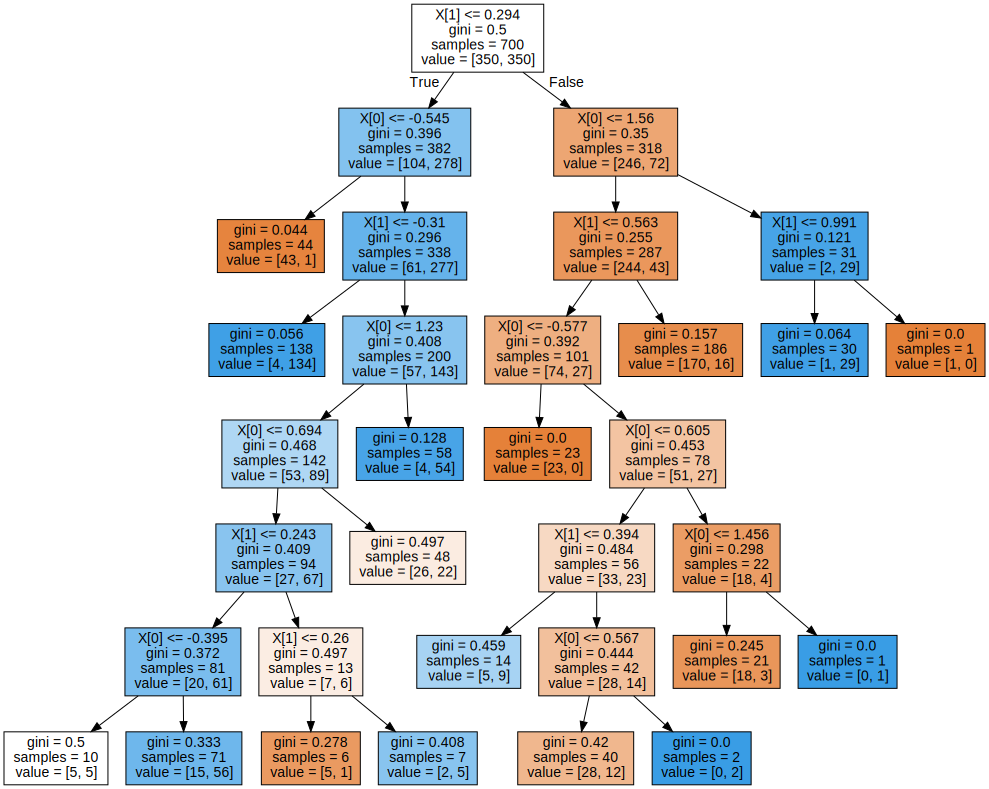

In [44]:
from sklearn.tree import export_graphviz
export_graphviz(tree_clf0, out_file="tree.dot",
                impurity=True, filled=True)

import graphviz
# 위에서 생성된 tree.dot 파일을 Graphiviz 가 읽어서 시각화
with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

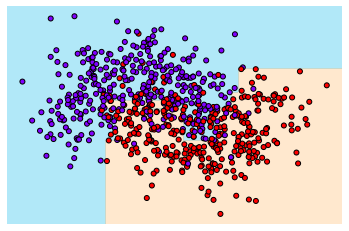

In [45]:
# 결정 경계 시각화
def visualize_boundary(model, X, y):
    fig,ax = plt.subplots()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=25, cmap='rainbow', edgecolor='k',
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim_start , xlim_end = ax.get_xlim()
    ylim_start , ylim_end = ax.get_ylim()
     
    model.fit(X, y)
    # meshgrid 형태인 모든 좌표값으로 예측 수행. 
    xx, yy = np.meshgrid(np.linspace(xlim_start,xlim_end, num=200),np.linspace(ylim_start,ylim_end, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    # contourf() 를 이용하여 class boundary를 visualization 수행. 
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap='rainbow', clim=(y.min(), y.max()),
                           zorder=1)
    
visualize_boundary(tree_clf0,x_train, y_train)

## 8번

In [46]:
from sklearn.model_selection import ShuffleSplit

# ShuffleSplit 분할기
ss = ShuffleSplit(n_splits=1000, train_size=100, test_size=0.05, random_state=42)

# 확인
train = []
for train_index, test_index in ss.split(x_train):
    train.append(train_index)
print('나눠진 훈련 데이터 갯수: ',len(train))
print('하나의 훈련 데이터 예시: \n',train[0])

나눠진 훈련 데이터 갯수:  1000
하나의 훈련 데이터 예시: 
 [432 559 483 517 132 176  72 254 578 650 596 667 352  76 148 346  90 541
  10  63 636 525 174 256 668  31 369 485  77 666 549 211  55 135 672 340
   2 227  81 473 695 511 605 120 311 204 244 687 271 131 681  60 310  30
  69 601 390  44 626  70 516 655 249 209 165 470 164 641 323  65 409  49
 118 192  39 259 422   6 101 543 299 395 582 318 145 487 353 208 696 361
  86 631 482 634  41 108 691  56 424 515]


In [47]:
ss_accuracy = []
n_iter = 0
for train_index, test_index in ss.split(x_train):
    X_train = x_train[train_index]
    Y_train = y_train[train_index]
    
    n_iter +=1
    tree_clf0.fit(X_train,Y_train)
    pred = tree_clf0.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    accuracy = np.round(accuracy, 5)
    ss_accuracy.append(accuracy)
    if 5 <= n_iter and n_iter <= 10:
        print(n_iter,'번째 모델의 정확도: ', accuracy)
print(np.round(np.mean(ss_accuracy),5))

5 번째 모델의 정확도:  0.78667
6 번째 모델의 정확도:  0.74333
7 번째 모델의 정확도:  0.85333
8 번째 모델의 정확도:  0.83333
9 번째 모델의 정확도:  0.87
10 번째 모델의 정확도:  0.82333
0.82069


*각 테스트 세트 샘플에 대한 1,000개의 결정 트리 예측 다수결 투표*

In [48]:
len(x_test)

300

In [50]:
test_predict = [[0] for _ in range(1000)]
ind = 0
for train_index, test_index in ss.split(x_train):
    X_train = x_train[train_index]
    Y_train = y_train[train_index]
    
    tree_clf0.fit(X_train,Y_train)
    pred = tree_clf0.predict(x_test)
    test_predict[ind] = pred
    ind +=1
test_predict[:2]

[array([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
        0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 

In [56]:
# 다수결 voting을 통한 최종 predict
from scipy.stats import mode

predict = mode(test_predict, axis = 0)
predict[0][0]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0])

In [55]:
accuracy = accuracy_score(y_test, predict[0][0])
accuracy = np.round(accuracy, 5)
print('최종 정확도: ',accuracy)

최종 정확도:  0.91
